In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format  

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [71]:
df=pd.read_csv('./datasets/원본data.csv',index_col=0)
df=df.drop(['원위안', '유가', '은', '외환보유액','구리'],axis=1) # G7 이미 삭제된 데이터셋
dataset =df.values
# dataset=df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']].values
scaler=StandardScaler()
dataset= scaler.fit_transform(dataset)
print(dataset)

[[ 0.93589755  1.43327182 -0.74157178 ...  2.07114449 -1.74913464
  -1.49457805]
 [ 0.80523213  1.42294476 -0.75485022 ...  2.01342627 -1.57284691
  -1.75012721]
 [ 0.7220814   1.26803893 -0.75485022 ...  2.85611229 -1.33988349
  -1.81061445]
 ...
 [-1.58238152 -0.73540982  0.37381684 ... -0.75285063  1.76937084
  -0.3938106 ]
 [-1.61801754 -0.73540982 -0.40961088 ... -0.59701144  1.4817088
  -0.27075728]
 [-1.66553224 -0.61148516 -0.3432187  ... -0.94751845  1.95422583
  -0.27316174]]


In [72]:
scaled_df = pd.DataFrame(dataset, columns=df.columns,index=df.index)
feature_df = scaled_df[['재고순환지표', '경제심리지수', '기계류내수출', '건설수주액', '수출입물가비율', '코스피', '장단기', '뉴스심리지수', '원달러', '원엔', 'CD', 'G20', '미장단기', '거래량', '천연가스', '금','종가']]
label_df = scaled_df['종가']
feature_df_2 = feature_df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]

In [73]:
feature_np = feature_df_2.to_numpy()
label_np = label_df.to_numpy()

In [74]:
feature_np.shape

(184, 9)

In [75]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터셋 생성 함수
def make_sequence_dataset(feature, label, window_size):
    feature_list = []
    label_list = []

    for i in range(len(feature) - window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size-1])

    return np.array(feature_list), np.array(label_list)

# 데이터셋 및 윈도우 크기 설정
window_size = 2

# 데이터셋 생성
X, Y = make_sequence_dataset(feature_np, label_np, window_size)

# 훈련 데이터와 테스트 데이터 분할
split = -36
x_train = X[:split]
y_train = Y[:split]
x_test = X[split:]
y_test = Y[split:]

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), dropout=0.18, recurrent_dropout=0.15))
model.add(LSTM(128, return_sequences=True, dropout=0.18, recurrent_dropout=0.15))
model.add(LSTM(128, return_sequences=False, dropout=0.18, recurrent_dropout=0.15))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# 초기 학습
model.fit(x_train, y_train, epochs=130, batch_size=6, verbose=1)

# 테스트 데이터의 예측
val_predictions = []
for i in range(len(x_test)):
    # 현재 입력 데이터
    current_feature = x_test[i:i+1]

    # 현재 예측
    current_prediction = model.predict(current_feature)[0]

    # 다음 레이블
    next_label = y_test[i]

    # 현재 입력 데이터와 예측 결과를 이용하여 모델 업데이트
    model.fit(current_feature, np.array([next_label]), epochs=5, batch_size=6, verbose=0)

    # 예측 결과 추가
    val_predictions.append(current_prediction)

# 예측 결과 출력
print("Validation Predictions:", val_predictions)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 2, 256)            272384    
                                                                 
 lstm_19 (LSTM)              (None, 2, 128)            197120    
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 601,217
Trainable params: 601,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/130
25/25 [==============================] - 4s 10ms/step - loss: 0.7227
Epoch 2/130
25/25 [==============================] - 0s 10ms/step - loss: 0.1517
Epoch 3/130
25/25 

In [76]:
import pandas as pd
import numpy as np

# 예측 결과를 데이터프레임으로 변환
predictions_df = pd.DataFrame(val_predictions, columns=['Predictions'])

# 원본 테스트 데이터와 예측 결과를 병합하여 데이터프레임 생성
result_df = pd.concat([pd.DataFrame(y_test, columns=['Real']), predictions_df], axis=1)


# 역 변환기
scaler_y = StandardScaler()
scaled_data_y = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1,1))

# 예측 값 스케일 역변환
val_predictions = scaler_y.inverse_transform(val_predictions)

# 실제 값 스케일 역변환
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과와 실제 값 데이터프레임으로 변환

result_df['change_real']=val_predictions
result_df['chage_pred']= y_test

# 결과 데이터프레임 출력
result_df



,Real,Predictions,change_real,chage_pred
0,-1.662965,-1.451516,1017.193037,932.770000
1,-1.375081,-2.117727,751.202899,1047.710000
2,-1.102951,-0.947766,1218.319073,1156.360000
3,-1.198604,-1.096035,1159.121613,1118.170000
4,-0.960036,-1.227626,1106.582704,1213.420000
5,-0.430904,-0.937507,1222.415119,1424.680000
6,-0.320224,-0.342025,1460.165907,1468.870000
7,-0.447335,-0.213328,1511.548954,1418.120000
8,-0.086090,-0.337750,1461.872458,1562.350000
9,0.338022,-0.302104,1476.104541,1731.680000


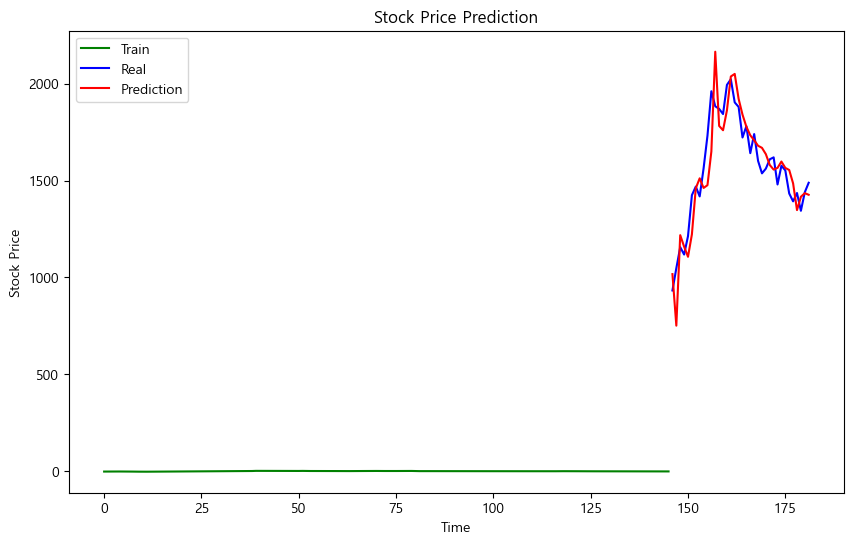

In [77]:
plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(y_train, color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), val_predictions, color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [78]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Calculate mean absolute error
mae = mean_absolute_error(val_predictions,y_test)
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(val_predictions, y_test)
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

#Calculate mean_absolute_percentage_error
mape = mean_absolute_percentage_error(val_predictions,y_test)
print('MAPE: %f' % mape)

MAE: 98.132368
MSE: 15944.500580
RMSE: 126.271535
MAPE: 0.068604
